# Accessibility Analysis

This notebook uses a 15-minute walkshed and NYC transit stations to create an accessibility index that measures access to a vaccine distribution location per census tract.

## Initialize and Import

In [1]:
# for data analysis
import pandas as pd

# for spatial data analysis
import geopandas as gpd

# for plotting
import matplotlib.pyplot as plt

# for basemaps
import contextily as ctx

# for the geometry
from shapely import wkt

# for interactive plots
import plotly.express as px

# to import open data from socrata
from sodapy import Socrata

import plotly.express as px

import folium

Bring in `iso.csv` and convert to a geodataframe with a Web Mercator Projection.

In [2]:
# bring in isochrone csv
iso = pd.read_csv('data/iso.csv')

# convert to gdf and set projection
iso['geometry'] = iso['geometry'].apply(wkt.loads)
iso = gpd.GeoDataFrame(iso, crs='epsg:3857')

Bring in the vaccine distribution locations as a geojson and set the projection to Web Mercator. 

In [3]:
# bring in vaccine locations
vac = gpd.read_file('data/vac.geojson')

# set projection
vac = vac.to_crs("EPSG:3857")

Bring in [NYC Subway Stations](https://data.ny.gov/resource/i9wp-a4ja.geojson) locations using Socrata.

In [4]:
# bring in NYC subway locations from Socrata

# connect to the data portal
client = Socrata("data.ny.gov", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("i9wp-a4ja", limit=2000)

# Convert to pandas DataFrame
stations_pd = pd.DataFrame.from_records(results)

# convert to geopandas geodataframe
stations = gpd.GeoDataFrame(
    stations_pd, 
    geometry=gpd.points_from_xy(stations_pd.station_latitude, stations_pd.station_longitude), 
    crs = "EPSG:3857")

# set projection
#stations = stations.set_crs("EPSG:3857").copy()

Bring in census tract shapefile

In [5]:
# import
ct = gpd.read_file('data/nyc_census_tracts')

# set projection
ct = ct.to_crs("EPSG:3857")

## Clean data
Clean the subway dataset to only include the name, lat, lon and convert the lat/lon to numbers.

In [6]:
# drop extra columns
stations = stations[['station_name', 'station_latitude', 'station_longitude', 'geometry']]

# drop duplicates
stations = stations.drop_duplicates(ignore_index = False)

In [7]:
# convert lat/lon to integers
stations['lat'] = pd.to_numeric(stations.station_latitude)
stations['lon'] = pd.to_numeric(stations.station_longitude)

# keep desired columns
stations = stations[['station_name', 'lat', 'lon', 'geometry']].copy()

## Dissolve isochrones

For the analysis, we're interested in neighborhoods that have 15-minute walk access to a vaccine distribution center. In order to simplify, I'll dissolve all of the polygons into one single polygon. Note that I've kept 'time' as a dummy variable to do the dissolve, even though all of the values are "15 mins." 

In [8]:
# select columns to keep after dissolve
isod = iso[['time', 'geometry']]

# dissolve the polygons by "time"
isod = isod.dissolve(by = 'time')

# Mapping

Plot the census tracts, walkshed, vaccine locations, and subway stations. Note: Need to figure out issue with projections (specifically stations and isod) in order plot on same graph.

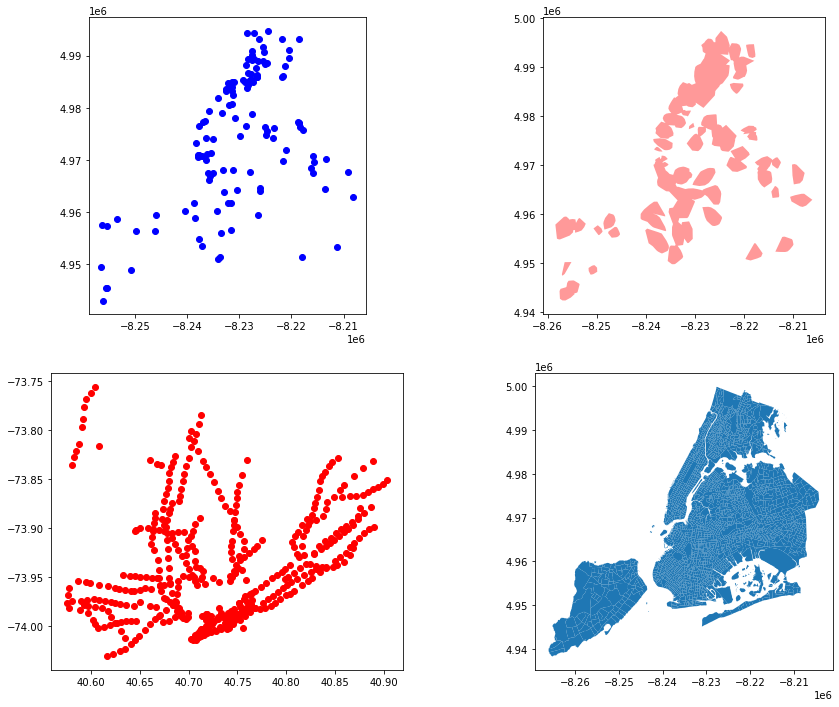

In [9]:
# set up the subplots
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2,2, figsize=(15,12))

# add the distribution location
vac.plot(ax=ax1,color='b')

# add the isochrones
isod.plot(alpha=0.4, ax=ax2, cmap='hsv', legend=True)

# add the subway stations
stations.plot(ax=ax3, color = 'r')

# add the census tracts
ct.plot(ax=ax4)

# hide the axis
#ax.axis('off')

# set axis limits
#ax.set_xlim(73.7, 74)
#ax.set_ylim(40.5, 40.9)

# give it a title
#ax.set_title('Accesibility Index')

# add the basemap
#ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# Analysis
In this section, I will use the walkshed polygon and the subway stations to create a vaccine accesibilty index for each census tract.